# **PHẦN 2: MÔ HÌNH HOÁ DỮ LIỆU**

## **1. Import các packages cần thiết**

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime 
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer

# from keras.layers import Dense
# from keras.models import Sequential
# from keras.optimizers import SGD
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, cross_validate, KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

pd.set_option('display.max_columns', None)
import warnings 
warnings.filterwarnings("ignore")

## **2. Đọc dữ liệu từ file csv**

In [28]:
df = pd.read_csv('./features/processed.csv')
df.shape

(48291, 24)

In [29]:
df.sample(5)

id            sku  \
17691  169818065  8339871612598   
14037  201538280  8076239202376   
47014  195928314  8504659912750   
3886   206537493  7541195937115   
25958  202183226  6721389304050   

                                                    name  \
17691        Cuốn Sách Tô Màu Đầu Tiên Của Tớ - Động Vật   
14037  Combo 2Q Phải Đọc Dành Cho Nhà Lãnh Đạo :  Lãn...   
47014              Sách: Tuổi dậy thì có điều gì kỳ diệu   
3886   Celine Dion - Câu Chuyện Đời Tôi, Giấc Mơ Tron...   
25958           Phương Pháp Dạy Con Không Đòn Roi (2022)   

                                               short_url book_cover   price  \
17691  https://tiki.vn/product-p169818065.html?spid=1...        NaN   21000   
14037  https://tiki.vn/product-p201538280.html?spid=2...    Bìa mềm  184000   
47014  https://tiki.vn/product-p195928314.html?spid=1...        NaN   79000   
3886   https://tiki.vn/product-p206537493.html?spid=2...    Bìa mềm  255000   
25958  https://tiki.vn/product-p202183226.html?spid=2...        NaN  109850   

       original_price  discount_rate  rating_average  review_count  \
17691           25000             16             0.0             0   
14037          230000             20             0.0             0   
47014           79000              0             0.0             0   
3886           255000              0             0.0             0   
25958          169000             35             0.0             0   

      inventory_type                              productset_group_name  \
17691      backorder  Nhà Sách Tiki/Sách tiếng Việt/Sách thiếu nhi /...   
14037      backorder  Nhà Sách Tiki/Sách tiếng Việt/Sách kinh tế/Sác...   
47014      backorder  Nhà Sách Tiki/Sách tiếng Việt/Sách Tâm lý - Gi...   
3886       backorder  Nhà Sách Tiki/Sách tiếng Việt/Sách văn học/Tiể...   
25958      backorder  Nhà Sách Tiki/Sách tiếng Việt/Sách Bà mẹ - Em ...   

       day_ago_created               categories  all_time_quantity_sold  \
17691              263     Tô màu - Luyện chữ                         5   
14037               46  Sách quản trị, lãnh đạo                       0   
47014              100    Sách Tâm Lý Tuổi Teen                       0   
3886                11         Tiểu sử - Hồi ký                       0   
25958               43          Sách Làm Cha Mẹ                       1   

                                            authors  \
17691                                           NaN   
14037   Robin Sharma, Noel Weyrich, Keith Ferrrazzi   
47014                                           NaN   
3886                                            NaN   
25958                                           NaN   

                                       publisher_vn     publication_date  \
17691                                       Đinh Tị                  NaN   
14037                                       NXB Trẻ                  NaN   
47014                          Sách điện tử Thái Hà                  NaN   
3886   Công ty Cổ Phần Văn Hóa và Giáo Dục Tân Việt  2022-11-21 21:12:17   
25958                                    1980 Books                  NaN   

      dimensions           manufacturer  number_of_page dich_gia edition luu_y  
17691        NaN                    oem               0      NaN     NaN   NaN  
14037        NaN     Nhiều Nhà Xuất Bản               0      NaN     NaN   NaN  
47014        NaN  Nhà Xuất Bản Lao Động               0      NaN     NaN   NaN  
3886         NaN  Nhà Xuất Bản Hồng Đức             412      NaN     NaN   NaN  
25958        NaN  Nhà Xuất Bản Lao Động               0      NaN     NaN   NaN

## **3. Xác định câu hỏi cần trả lời:**
**Bài toán dự đoán `discount_rate` dựa trên các đặc trưng của sản phẩm.**
- Đây là một bài toán hồi quy.
- Input là các đặc trưng ảnh hưởng đến tỉ lệ giảm giá của một mặt hàng sách.
- Output là tỉ lệ giảm giá của sách. 

**Trả lời được câu hỏi này sẽ giúp cho cả khách hàng và nhà bán có những lợi ích sau:**
- Nhà bán quyết định mức sale phù hợp với thị trường, từ đó bán được nhiều sản phẩm hơn.
- Người mua chọn được sản phẩm giá rẻ, có mức sale cao, dựa vào việc xem xét qua các đặc trưng khác.

## **4. Phân tích, xử lý và chuẩn bị dữ liệu cho bước mô hình hoá**

Các cột có kiểu dữ liệu là numeric 

In [30]:
numeric_cols = df.select_dtypes(include=np.number).columns
numeric_cols

Index(['id', 'sku', 'price', 'original_price', 'discount_rate',
       'rating_average', 'review_count', 'day_ago_created',
       'all_time_quantity_sold', 'number_of_page'],
      dtype='object')

In [31]:
numeric_profiles = {'missing_ratio': df[numeric_cols].isna().sum() * 100.0/len(df[numeric_cols]),
                        'min': df[numeric_cols].min(),
                        'max': df[numeric_cols].max()}
nume_col_profiles_df = pd.DataFrame(numeric_profiles).transpose()
nume_col_profiles_df

,id,sku,price,original_price,discount_rate,rating_average,review_count,day_ago_created,all_time_quantity_sold,number_of_page
missing_ratio,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00
min,148562.0,1.000110e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00
max,207990688.0,9.999995e+12,6000000.0,6950000.0,91.0,5.0,6306.0,2689.0,32323.0,9.786049e+12


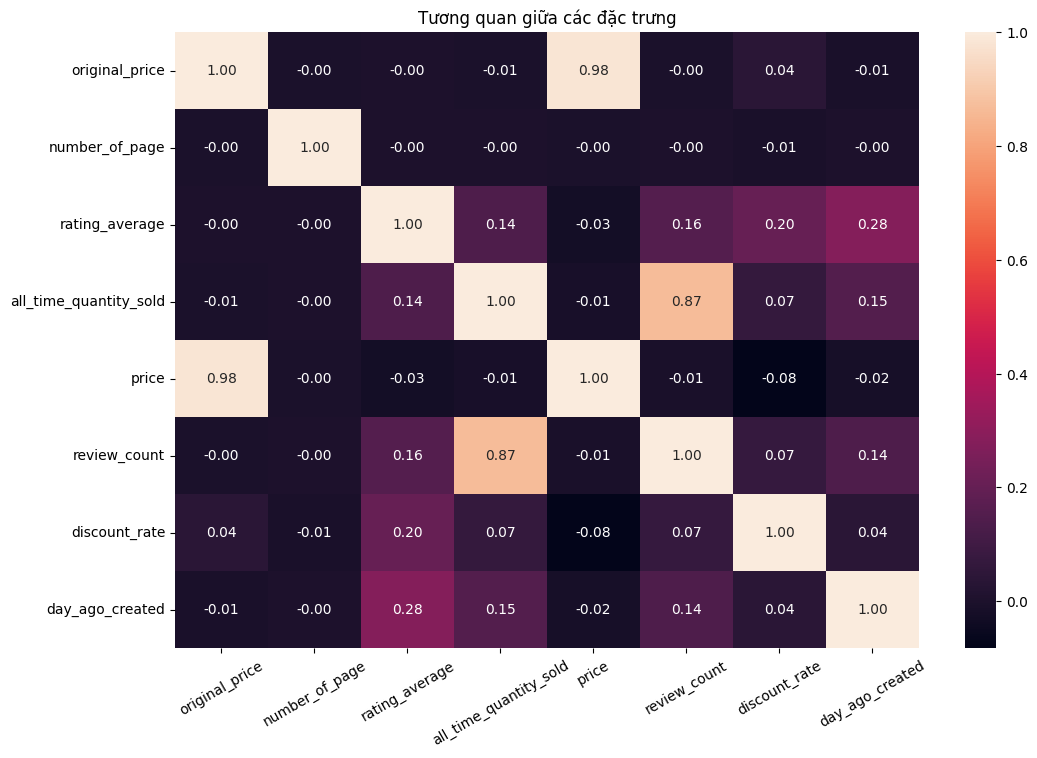

In [32]:
plt.figure(figsize=(12,8))
sns.heatmap(df[set(numeric_cols) - {'id', 'sku'}].corr(), annot=True, fmt='.2f')
plt.xticks(rotation=30)
plt.title('Tương quan giữa các đặc trưng')
plt.show()

In [33]:
cate_cols = set(df.columns) - set(numeric_cols)
cate_profiles = {'missing_ratio': df[cate_cols].isna().sum() * 100.0/len(df[cate_cols]),
               #   'zero_values_ratio':  df[cate_cols].eq(0).sum(axis=1) * 100.0/len(df[cate_cols]),
                      'num_diff_vals': df[cate_cols].nunique(dropna=True),
                      'diff_vals': df[cate_cols].stack(dropna=True).groupby(level=[1]).unique(),
                      }
cate_col_profiles_df = pd.DataFrame(cate_profiles).transpose()
cate_col_profiles_df

,authors,book_cover,categories,dich_gia,dimensions,edition,inventory_type,luu_y,manufacturer,name,productset_group_name,publication_date,publisher_vn,short_url
missing_ratio,48.804125,35.358555,0.0,85.686774,82.744197,96.931105,0.0,99.995858,0.550827,0.0,0.0,61.158394,0.035203,0.0
num_diff_vals,9094,17,100,3110,1051,364,3,1,168,44424,101,10896,852,48288
diff_vals,"[Trần Đặng Đăng Khoa, Trần Hồng Ngọc, Lê Quang...","[Bìa mềm, Bìa Da, Bìa cứng, Bìa gập, Bìa rời, ...","[Du ký, Light novel, Phê Bình - Lý Luận Văn Họ...","[Khánh Vân, Phan Quang, Nguyễn Thị Bạch Tuyết,...","[13 x 20, 14,5 x 20,5 cm, 13.5 x 20.5 cm, 15 x...","[bìa mềm, BÌA MỀM, Tiếng Việt, Tặng kèm bookma...","[instock, backorder, preorder]",[Sách không còn kèm CD mà thay bằng ứng dụng t...,"[NXB Trẻ, Nhà Xuất Bản Lao Động, Nhà Xuất Bản ...",[1111 - Nhật Ký Sáu Vạn Dặm Trên Yên Xe Cà Tàn...,[Nhà Sách Tiki/Sách tiếng Việt/Sách văn học/Du...,"[2022-11-10 00:00:00, 2022-11-11 17:44:46, 202...","[NXB Trẻ, Chibooks, Văn Lang, Edibooks, NXB Ph...",[https://tiki.vn/product-p204317934.html?spid=...


In [34]:
cate_col_profiles_df.loc['diff_vals', 'categories']

array(['Du ký', 'Light novel', 'Phê Bình - Lý Luận Văn Học',
       'Phóng sự - Ký sự - Bút ký', 'Tác phẩm kinh điển', 'Thơ',
       'Tiểu sử - Hồi ký', 'Tiểu Thuyết',
       'Truyện Giả tưởng - Huyền Bí - Phiêu Lưu', 'Tranh Truyện',
       'Truyện cổ tích - Ngụ ngôn', 'Truyện cười', 'Truyện dài',
       'Bài học kinh doanh', 'Truyện đam mỹ', 'Truyện kiếm hiệp',
       'Truyện kinh dị', 'Truyện ngắn - Tản văn - Tạp Văn',
       'Truyện ngôn tình', 'Truyện trinh thám', 'Ca dao - Tục ngữ',
       'Sách ảnh', 'Sách doanh nhân', 'Sách khởi nghiệp',
       'Sách kinh tế học', 'Sách kỹ năng làm việc',
       'Sách Marketing - Bán hàng ', 'Sách quản trị, lãnh đạo',
       'Sách quản trị nhân lực', 'Sách tài chính, kế toán',
       'Sách tài chính, tiền tệ', 'Đạo đức - Kỹ năng sống',
       'Kiến thức - Bách khoa', 'Tô màu - Luyện chữ  ', 'Truyện cổ tích',
       'Truyện kể cho bé', 'Truyện tranh Ehon', 'Truyện tranh thiếu nhi',
       'Văn học thiếu nhi', 'Sách tư duy - Kỹ năng sống',
       

Chọn ra các features phù hợp/ có ảnh hưởng đến yêu cầu bài toán làm đầu vào cho mô hình 

In [35]:
cols = ['original_price', 'discount_rate',
       'rating_average', 'review_count', 'day_ago_created',
       'all_time_quantity_sold', 'number_of_page']
# Thêm một vài cột categories có ý nghĩa đối với output
cate = ['book_cover', 'categories', 'inventory_type', 'manufacturer', 'publication_date']
cols.extend(cate)

Xem qua kiểu dữ liệu của các cột

In [36]:
df[cols].dtypes

original_price              int64
discount_rate               int64
rating_average            float64
review_count                int64
day_ago_created             int64
all_time_quantity_sold      int64
number_of_page              int64
book_cover                 object
categories                 object
inventory_type             object
manufacturer               object
publication_date           object
dtype: object

In [37]:
df[['categories', 'inventory_type', 'manufacturer']] = df[['categories', 'inventory_type', 'manufacturer']].astype(str)
df[['categories', 'inventory_type', 'manufacturer']]

,categories,inventory_type,manufacturer
0,Du ký,instock,NXB Trẻ
1,Du ký,backorder,NXB Trẻ
2,Du ký,instock,Nhà Xuất Bản Lao Động
3,Du ký,backorder,Nhà Xuất Bản Hồng Đức
4,Du ký,backorder,NXB Trẻ
...,...,...,...
48286,Thể Dục - Thể Thao,backorder,Nhà Xuất Bản Hà Nội
48287,Thể Dục - Thể Thao,backorder,NXB Trẻ
48288,Thể Dục - Thể Thao,backorder,Nhà Xuất Bản Đại Học Quốc Gia Hà Nội
48289,Thể Dục - Thể Thao,backorder,Nhà Xuất Bản Thể Thao Và Du Lịch


Cột `publication_date` đang có kiểu dữ liệu là object, ta cũng cần chuyển về datetime cho phù hợp

In [38]:
df['publication_date'] = pd.to_datetime(df.publication_date, format = "%Y-%m-%d %H:%M:%S", errors = "coerce")

Có lẽ ta không cần cột này trong đầu vào của mô hình vì cột `day_ago_created` đã có ý nghĩa tương tự

In [39]:
cols.remove('publication_date')

**Xem một vài phân bố của các đặc trưng, từ đó giúp ta quan sát outliers, độ tập trung của dữ liệu**

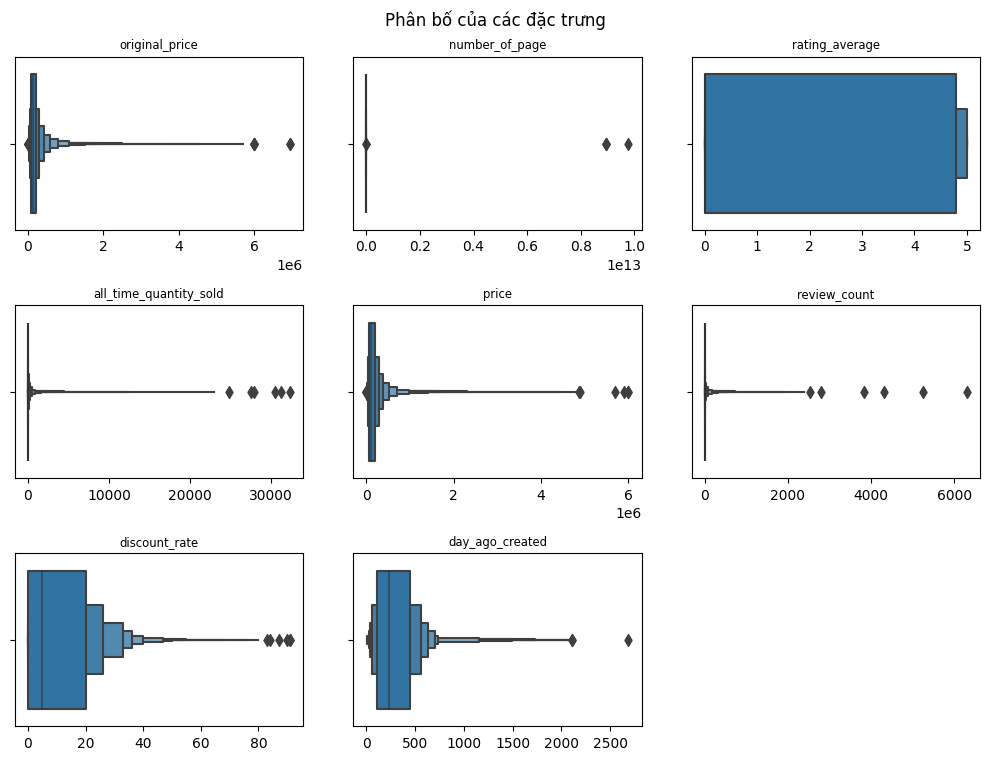

In [40]:
# df_cont = df.select_dtypes([int,float]) 
numeric_df = df[set(numeric_cols) - {'id', 'sku'}]

fig = plt.figure(figsize=(10, 10))
fig.suptitle('Phân bố của các đặc trưng')
for i,col in enumerate(numeric_df.columns, 1): 
    ax = plt.subplot(4,3,i) 
    sns.boxenplot(data = numeric_df, x=numeric_df[col]) 
    plt.xlabel(None)
    plt.title(col, fontsize='small')
    plt.tight_layout(w_pad=3) 

plt.show() 

Hầu như các cột dữ liệu đều bị lệch phải (right-skewed)
- <font color=bone>*original_price*</font> và <font color=bone>*price*</font> có phân bố khá giống nhau, có vài điểm outliers khá lớn
- <font color=bone>*day_ago_created*</font> thì phân bố tập trung trong khoảng 0-500 và giảm dần về 2000
- <font color=bone>*rating_average*</font> phân bố khá đồng đều từ 0 đến 5
- <font color=bone>*all_time_quantity_sold*</font> phân bố chủ yếu ở giá trị 0, xấp xỉ 0 và rải rác từ 0 đến hơn 30000
- <font color=bone>*review_count*</font> cũng tương tự, tuy nhiên nằm rải rác từ 0 đến hơn 6000
- <font color=bone>*discount_rate*</font> chủ yếu phân bố từ 0-40 và thưa thớt ở các giá trị rate cao hơn
- Riêng với <font color=bone>*number_of_page*</font> có outlier khá "khủng" nên ta sẽ xử lý riêng và vẽ lại biểu đồ của cột này

Text(0.5, 1.0, 'Phân bố của number_of_page sau khi clip các giá trị ngoại lệ')

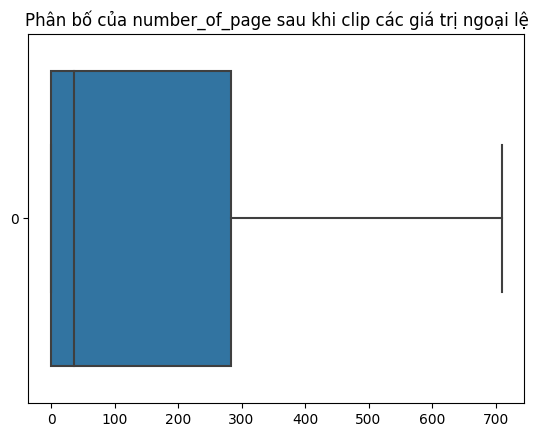

In [41]:
# ref: https://machinelearningcoban.com/tabml_book/ch_data_processing/process_outliers.html
from typing import Tuple
from sklearn.base import BaseEstimator, TransformerMixin
def find_boundaries(col: pd.Series, whisker_coeff: float = 1.5
) -> Tuple[float, float]:
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - whisker_coeff * IQR
    upper = Q3 + whisker_coeff * IQR
    return lower, upper

class BoxplotOutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, whisker_coeff: float = 1.5):
        self.whisker = whisker_coeff
        self.lower = None
        self.upper = None

    def fit(self, X: pd.Series):
        self.lower, self.upper = find_boundaries(X, self.whisker)
        return self

    def transform(self, X):
        return X.clip(self.lower, self.upper)

numeric_df['number_of_page_clipped'] = BoxplotOutlierClipper().fit_transform(numeric_df['number_of_page'])
# print(numeric_df['number_of_page'].sort_values(ascending=False)[30:60])
sns.boxplot(data = numeric_df['number_of_page_clipped'].reset_index(drop=True)
              , orient='h')
plt.title('Phân bố của number_of_page sau khi clip các giá trị ngoại lệ') 
# plt.xlim(0, 1e4)

**Các cột có giá trị thiếu hay không? Nếu thiếu thì xử lý như thế nào?**

In [42]:
df[cols].isna().sum()

original_price                0
discount_rate                 0
rating_average                0
review_count                  0
day_ago_created               0
all_time_quantity_sold        0
number_of_page                0
book_cover                17075
categories                    0
inventory_type                0
manufacturer                  0
dtype: int64

Cột `book_cover` thiếu khá nhiều, ta sẽ xem qua các giá trị của cột này

In [43]:
df['book_cover'].value_counts()

Bìa mềm                                     27766
Bìa cứng                                     2922
Bìa gập                                       366
Bìa Da                                         43
Bìa rời                                        26
B Format Paperback                             22
Bìa Da Công Nghiệp Microfiber                  21
Box                                            14
Boxset                                         12
Tùy chọn phiên bản bìa cứng hoặc bìa mềm        9
Paperback                                       7
Board book                                      2
Mix Media Pack                                  2
Jigsaw box                                      1
Counterpack holds 48 Mini Activity Books        1
B-format Paperback                              1
Hardcover                                       1
Name: book_cover, dtype: int64

Ngoài ra, cột <font color=bone>number_of_page</font> chứa các giá trị 0 cũng khá vô lý (cuốn sách có 0 trang?), một suy đoán cho những giá trị này có thể là do thiếu dữ liệu về số trang nên sẽ mặc định là 0. 
- Có thể phải bỏ các dòng có giá trị này để tránh thêm vào điểm dữ liệu bất hợp lý?
- Một cách khác là điền vào các giá trị theo mật độ xuất hiện của các giá trị đã biết?

In [44]:
df[df['book_cover'].isna()].sample(5)

,id,sku,name,short_url,book_cover,price,original_price,discount_rate,rating_average,review_count,inventory_type,productset_group_name,day_ago_created,categories,all_time_quantity_sold,authors,publisher_vn,publication_date,dimensions,manufacturer,number_of_page,dich_gia,edition,luu_y
17050,174259422,8455180970185,Combo 6 Cuốn: Kĩ Năng Vàng Cho Teen Thế Kỉ 21,https://tiki.vn/product-p174259422.html?spid=1...,NaN,420000,420000,0,5.0,2,backorder,Nhà Sách Tiki/Sách tiếng Việt/Sách thiếu nhi /...,236,Kiến thức - Bách khoa,12,NaN,NXB Kim Đồng,NaT,NaN,Nhà Xuất Bản Kim Đồng,0,NaN,NaN,NaN
6528,193206153,6257903893774,Bí Kíp Hạ Phàm( Bộ 2 Tập),https://tiki.vn/product-p193206153.html?spid=1...,NaN,189000,279000,32,5.0,1,instock,Nhà Sách Tiki/Sách tiếng Việt/Sách văn học/Tru...,122,Truyện đam mỹ,11,Lữ Thiên Dật,Công Ty TNHH Sách Trí Tuệ Việt,2021-01-01,NaN,Nhà Xuất Bản Văn Học,0,Uyên Uyên,NaN,NaN
39836,143018601,4028391025348,Combo 3 cuốn: Súng vi trùng và Thép + Biến Độn...,https://tiki.vn/product-p143018601.html?spid=1...,NaN,805000,947000,15,0.0,0,backorder,Nhà Sách Tiki/Sách tiếng Việt/Sách Lịch sử/Lịc...,374,Lịch Sử Thế Giới,0,Jared Diamond,Alphabooks,NaT,NaN,Nhà Xuất Bản Dân Trí,0,NaN,NaN,NaN
1359,110361355,7676628331112,WORLD WARR II - ĐỆ NHỊ THẾ CHIẾN,https://tiki.vn/product-p110361355.html?spid=1...,NaN,220000,220000,0,0.0,0,backorder,Nhà Sách Tiki/Sách tiếng Việt/Sách văn học/Phó...,516,Phóng sự - Ký sự - Bút ký,0,NaN,Công ty TNHH TM & DV Văn Hóa Hương Trang,NaT,NaN,Nhà Xuất Bản Hồng Đức,0,NaN,NaN,NaN
32610,182739474,6019169210398,Chuyên Đề Chuyên Sâu Bồi Dưỡng Ngữ Văn 10 (Dùn...,https://tiki.vn/product-p182739474.html?spid=1...,NaN,60000,60000,0,0.0,0,backorder,Nhà Sách Tiki/Sách tiếng Việt/Sách Tham Khảo/S...,193,Sách tham khảo cấp III,1,NaN,Nhà Sách Hồng Ân,NaT,NaN,Nhà Xuất Bản Đại Học Quốc Gia Hà Nội,0,NaN,NaN,NaN


Thay các giá trị 0 thành nan để phục vụ cho giai đoạn xử lý missing value 

In [45]:
df['number_of_page'].replace(0, np.nan, inplace=True)

### **Xử lý các giá trị ngoại lệ**

In [46]:
df['number_of_page'] = BoxplotOutlierClipper().fit_transform(df['number_of_page'])

In [47]:
features = df[cols].copy()

#### **Phân chia tập train/val/test**

In [48]:
x_df = features[set(cols) - {'discount_rate'}]
y_df = features['discount_rate']

x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=5) # Tách tập test/train
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=5) # Tách tập train/val từ tập train


#### **Pipeline cho bước tiền xử lý**

In [49]:
# df['book_cover'].fillna('Không có bìa', inplace=True)
cate = [ 'book_cover', 'categories','inventory_type', 'manufacturer']
nume = ['original_price', 'rating_average', 'review_count', 'day_ago_created','all_time_quantity_sold',
        'number_of_page']

# Pipeline xử lý cho các cột category
cate_transformer = Pipeline(steps= [('imputer', SimpleImputer(strategy='most_frequent')), # Thay thế missing value bằng giá trị có tần suất xuất hiện cao
                               ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore'))]) # biểu diễn one hot cho các cột category
                                                                                # đối với các giá trị mà model chưa từng thấy bao giờ (trong tập test) thì ta bỏ qua
# Pipeline xử lý cho các cột numeric
nume_transfomer = Pipeline(steps= [('imputer', KNNImputer(n_neighbors=10)), # thay thế missing value bằng thuật toán k-nearest với số lượng láng giềng là 10
                                   ('scaler', MinMaxScaler())])  # scale các giá trị về miền giá trị trong khoảng 0 đến 1 

# Pipeline cho bước tiền xử lý chung 
preprocessor = ColumnTransformer(transformers=[('cate_transformer', cate_transformer, cate),
                                                ('nume_transfomer',nume_transfomer, nume)])

## **5. Huấn luyện mô hình**

#### **Linear Regression**

In [50]:
model = LinearRegression()
lr_pl = Pipeline(steps=[('preprocessor', preprocessor),
                                ('linear_regression', model)])


lr_pl.fit(x_train, y_train)
y_train_pred = lr_pl.predict(x_train)

In [51]:
y_test_pred = lr_pl.predict(x_test)

In [52]:
print(f'Train set: [MSE: {mean_squared_error(y_train, y_train_pred):.3f}, MAE: {mean_absolute_error(y_train, y_train_pred):.3f}]')
print(f'Test set: [MSE: {mean_squared_error(y_test, y_test_pred):.3f}, MAE: {mean_absolute_error(y_test, y_test_pred):.3f}]')


Train set: [MSE: 108.656, MAE: 8.093]
Test set: [MSE: 109.089, MAE: 8.093]


Mô hình này cho ra độ lỗi khá tốt

#### **Cross validation**

In [53]:
# Xác định KFold
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
cv = KFold(n_splits = 5, shuffle = True, random_state = 100)

cv_pl = Pipeline(
    steps=[("preprocessor", preprocessor), ('regression', LinearRegression())])

scores_cv = cross_validate(cv_pl, x_train, y_train, scoring=['neg_mean_absolute_error','neg_mean_squared_error'], 
                           cv=cv, error_score='raise')
 

In [56]:
scores_cv

{'fit_time': array([19.5660789 , 22.41852379, 18.46125126, 18.75126791, 18.94825482]),
 'score_time': array([5.02752995, 4.63515568, 4.63202739, 4.75026798, 4.44282722]),
 'test_neg_mean_absolute_error': array([-8.09780729, -8.14291943, -8.14661257, -8.26680874, -8.13795453]),
 'test_neg_mean_squared_error': array([-107.44886289, -110.21544083, -111.09801375, -111.47541862,
        -112.0272968 ])}

In [59]:
print('Mean NMAE: {:.03f}, Std: {:.03f}'
      .format(np.mean(scores_cv['test_neg_mean_absolute_error'], dtype=np.float64), np.std(scores_cv['test_neg_mean_absolute_error'])))
print('Mean NMSE: {:.03f}, Std: {:.03f}'
      .format(np.mean(scores_cv['test_neg_mean_squared_error'], dtype=np.float64), np.std(scores_cv['test_neg_mean_squared_error'])))

Mean NMAE: -8.158, Std: 0.057
Mean NMSE: -110.453, Std: 1.614


#### **Đánh giá nhiều mô hình với nhiều metric khác nhau**

In [60]:
models = [LinearRegression(), RandomForestRegressor(), GradientBoostingRegressor(), TransformedTargetRegressor()]

# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
cv = KFold(n_splits = 5, shuffle = True, random_state = 100)

all_scores = []
metric = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error']
# Đánh giá toàn bộ các mô hình trên tập K-Fold đã chia
for model in models:
  multi_model_pl = Pipeline(
    steps=[("preprocessor", preprocessor), ('regression', model)]
  )

  scores = cross_validate(multi_model_pl, x_train, y_train, scoring=metric, cv=cv)
  print(str(model) + ' done!')
  all_scores.append(scores)

LinearRegression() done!
RandomForestRegressor() done!
GradientBoostingRegressor() done!
TransformedTargetRegressor() done!


In [61]:
all_scores_df = pd.DataFrame(all_scores)
# os.mkdir('./evaluating')
all_scores_df.to_csv('./evaluating/all_scores.csv', index_label=False)
all_scores_df.head()

,fit_time,score_time,test_neg_mean_squared_error,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,test_neg_mean_absolute_percentage_error
0,"[20.699440002441406, 18.606149673461914, 18.36...","[4.664328575134277, 4.539032459259033, 4.47117...","[-107.44886289396524, -110.21544082960116, -11...","[-8.097807285939364, -8.142919430442728, -8.14...","[-10.365754333089573, -10.498354196234816, -10...","[-1.5898539144158372e+16, -1.5981910727277648e..."
1,"[150.09874534606934, 146.53938055038452, 156.0...","[4.532428503036499, 4.772809743881226, 4.90838...","[-84.55692939959222, -83.94020691391293, -88.9...","[-6.616672780562229, -6.5698209579613005, -6.7...","[-9.19548418516351, -9.16188882894313, -9.4306...","[-1.1376071958673494e+16, -1.1843730770047422e..."
2,"[22.516953945159912, 21.311146020889282, 21.75...","[4.262818813323975, 4.540108919143677, 4.75889...","[-107.6562698579909, -108.4802476031433, -109....","[-8.315782051623883, -8.323245186828707, -8.36...","[-10.37575394166568, -10.415385139453235, -10....","[-1.628428042221606e+16, -1.6527654714956582e+..."
3,"[19.412809133529663, 20.373303413391113, 19.32...","[4.405459403991699, 4.850273132324219, 4.41099...","[-107.44886289396524, -110.21544082960116, -11...","[-8.097807285939364, -8.142919430442728, -8.14...","[-10.365754333089573, -10.498354196234816, -10...","[-1.5898539144158372e+16, -1.5981910727277648e..."


Tính mean và standard deviation của từng giá trị trong `all_scores_df`

In [62]:
models = ['LinearRegression', 'RandomForestRegressor', 'GradientBoostingRegressor', 'TransformedTargetRegressor']
def get_mean_std(x):
    return x.mean(), x.std()

all_scores_df.index = models
all_scores_df.applymap(get_mean_std)

,fit_time,score_time,test_neg_mean_squared_error,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,test_neg_mean_absolute_percentage_error
LinearRegression,"(18.96043930053711, 0.8783982097199173)","(4.53293924331665, 0.07320710110478458)","(-110.45300657878252, 1.6137575463328362)","(-8.15842051368069, 0.05695707030104924)","(-10.50937992310838, 0.077072761394665)","(-1.5835003223297856e+16, 318908958653418.75)"
RandomForestRegressor,"(151.64460091590882, 3.2115763835639792)","(4.706380701065063, 0.1353701923604475)","(-85.84372974934777, 1.8881810190243875)","(-6.6460572476776765, 0.05169978097509177)","(-9.264632515827232, 0.1015583380355829)","(-1.1618822646930756e+16, 237173962741091.75)"
GradientBoostingRegressor,"(21.845471954345705, 0.5707017304840806)","(4.534425067901611, 0.17208323441804715)","(-109.43660440471805, 1.1884117154293024)","(-8.372764431689802, 0.05458414714131124)","(-10.461040676846547, 0.05685386600731228)","(-1.6376821197119958e+16, 192537183786057.97)"
TransformedTargetRegressor,"(19.568842458724976, 0.4194052110056854)","(4.6656389236450195, 0.24551280780445842)","(-110.45300657878252, 1.6137575463328362)","(-8.15842051368069, 0.05695707030104924)","(-10.50937992310838, 0.077072761394665)","(-1.5835003223297856e+16, 318908958653418.75)"


Dựa vào bảng có thể thấy mô hình <font color=bone>RandomForest</font> cho độ lỗi tốt nhất, tuy nhiên <font color=bone>fit_time</font> và <font color=bone>score_time</font> là cao nhất.

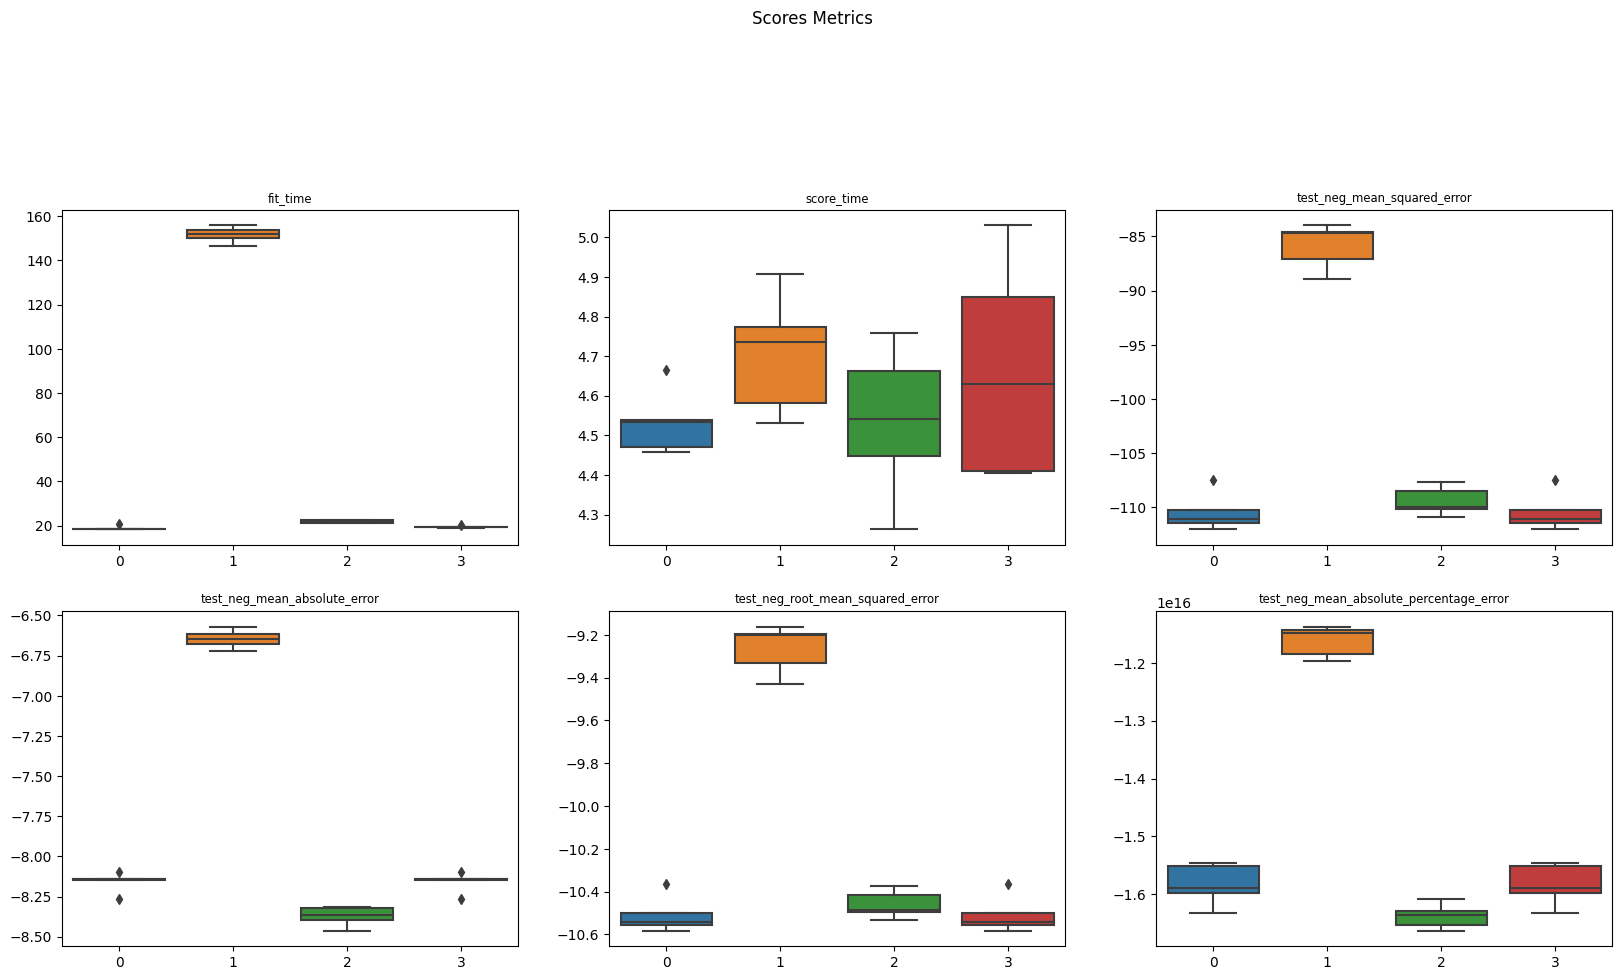

In [75]:
plt.figure(figsize=(20, 20))
plt.suptitle("Scores Metrics")
for i,col in enumerate(all_scores_df.columns, 1): 
    ax = plt.subplot(4,3,i) 
    sns.boxplot(all_scores_df[col])
    plt.title(col, fontsize='small')
    # plt.tight_layout(w_pad=3) 

Vậy mô hình được chọn là: RandomForestRegression

In [76]:
rf_pl = Pipeline(
    steps=[("preprocessor", preprocessor), ('RandomForestRegression', RandomForestRegressor())])

rf_pl.fit(x_train, y_train)
y_train_pred = rf_pl.predict(x_train)

In [77]:
y_test_pred = rf_pl.predict(x_test)

In [78]:
print(f'Train set: [MSE: {mean_squared_error(y_train, y_train_pred):.3f}, MAE: {mean_absolute_error(y_train, y_train_pred):.3f}]')
print(f'Test set: [MSE: {mean_squared_error(y_test, y_test_pred):.3f}, MAE: {mean_absolute_error(y_test, y_test_pred):.3f}]')

Train set: [MSE: 12.335, MAE: 2.447]
Test set: [MSE: 81.336, MAE: 6.458]


Có thể thấy độ lỗi trên tập train và tập test đều cải thiện khá nhiều so với các mô hình trên

### **Fine-tuning process**

Sử dụng kĩ thuật RandomizedSearchCV()

Phương pháp này tìm kiếm ngẫu nhiên trên không gian tham số, kết hợp với KFold và chọn ra bộ tham số tốt nhất cho mô hình. 

In [79]:
n_estimators = [200 , 400, 600, 800, 1000, 1200] # số lượng cây 
max_features = ['auto', 'sqrt'] # cách tính số lượng đặc trưng mỗi lần split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # độ sâu tối đa của cây
min_samples_split = [2, 6, 10] # số lượng mẫu tối thiểu trong một node
min_samples_leaf = [1, 3, 4] # số lượng mẫu tối thiểu trong một node lá
bootstrap = [True, False] # cách lấy mẫu (có hoàn lại hay không)

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

In [80]:
rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid, 
                               scoring='neg_mean_absolute_error', return_train_score=True,
                               n_iter = 100, cv = 5, verbose=2, random_state=10, n_jobs = 10)

completed_pl = Pipeline(
    steps=[("preprocessor", preprocessor), ('model', rf_random)])

completed_pl.fit(x_train, y_train)
y_train_pred = completed_pl.predict(x_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


Mất gần 10 tiếng để train.. 😅😢

In [85]:
y_test_pred = completed_pl.predict(x_test)

In [89]:
print(completed_pl)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cate_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('OneHotEncoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['book_cover', 'categories',
                                                   'inventory_type',
                                                   'manufacturer']),
                                                 ('nume_transfomer',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=10)),
                                                        

**Siêu tham số cho kết quả tốt nhất là:**

In [81]:
print ('Random grid: ', random_grid, '\n')
print ('Best Parameters: ', completed_pl['model'].best_params_, ' \n')

Random grid:  {'n_estimators': [200, 400, 600, 800, 1000, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 120, 'bootstrap': True}  



In [91]:
result = pd.DataFrame(completed_pl['model'].cv_results_)
result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,56.678743,2.168121,0.537876,0.017825,600,6,4,sqrt,30,False,"{'n_estimators': 600, 'min_samples_split': 6, ...",-8.094837,-7.998558,-8.038205,-8.083835,-8.019429,-8.046973,0.036958,88
1,73.392971,1.056641,0.711806,0.027177,600,6,3,sqrt,110,True,"{'n_estimators': 600, 'min_samples_split': 6, ...",-7.814854,-7.723986,-7.760226,-7.804310,-7.732664,-7.767208,0.036761,70
2,177.769721,4.696743,1.584416,0.020403,1200,2,4,sqrt,120,False,"{'n_estimators': 1200, 'min_samples_split': 2,...",-7.774306,-7.680802,-7.721054,-7.762625,-7.692181,-7.726194,0.037110,66
3,3633.126572,45.581103,7.162269,0.167508,1200,2,1,auto,80,False,"{'n_estimators': 1200, 'min_samples_split': 2,...",-7.488276,-7.392376,-7.493885,-7.411257,-7.372629,-7.431685,0.050043,33
4,136.180306,2.964917,1.130800,0.011652,800,10,3,sqrt,100,False,"{'n_estimators': 800, 'min_samples_split': 10,...",-7.654366,-7.574016,-7.599894,-7.645108,-7.575677,-7.609812,0.033987,43


Mô hình hoàn chỉnh với best parameters từ kỹ thuật Randomized search CV

In [95]:
rf = RandomForestRegressor(n_estimators=1000, min_samples_split=2, min_samples_leaf=1, 
                           max_features='auto', max_depth=120, bootstrap=True)

last_pl = Pipeline(
    steps=[("preprocessor", preprocessor), ('model', rf)])

last_pl.fit(x_train, y_train)
y_train_pred = last_pl.predict(x_train)

In [96]:
y_test_pred = last_pl.predict(x_test)

In [97]:
print(f'Train set: [MSE: {mean_squared_error(y_train, y_train_pred):.3f}, MAE: {mean_absolute_error(y_train, y_train_pred):.3f}]')
print(f'Test set: [MSE: {mean_squared_error(y_test, y_test_pred):.3f}, MAE: {mean_absolute_error(y_test, y_test_pred):.3f}]')

Train set: [MSE: 11.868, MAE: 2.429]
Test set: [MSE: 80.688, MAE: 6.450]


Không cải thiện nhiều lắm so với khi ta sử dụng thuật toán Random Forest mặc định (không tinh chỉnh các siêu tham số).

Vậy ta sẽ chọn RandomForestRegression với tham số mặc định để tối ưu thời gian chạy và độ lỗi của mô hình.